In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from pycocotools.coco import COCO
from PIL import Image

import torch.nn.functional as F

In [63]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 250        # number of epochs
LR = 0.00001         # Learning rate
IMG_SIZE = 320     # Size of image
BATCH_SIZE = 32    # Batch size 

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [65]:

def create_image_mask_dataframe(image_dir, annotation_file):
    # Initialize COCO and prepare data
    coco = COCO(annotation_file)
    image_ids = list(coco.imgs.keys())

    data = []

    for image_id in image_ids:
        # Get image information
        image_info = coco.loadImgs(image_id)[0]
        image_path = f"{image_dir}/{image_info['file_name']}"

        # Collect all annotations for the image
        annotation_ids = coco.getAnnIds(imgIds=image_id)
        annotations = coco.loadAnns(annotation_ids)

        # Create a mask for the image
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        for annotation in annotations:
            if 'segmentation' in annotation:
                mask = np.maximum(mask, coco.annToMask(annotation))

        # Append to data list
        data.append({
            "image_path": image_path,
            "mask": mask  # Alternatively, save masks to files and store paths
        })

    # Create a DataFrame
    df = pd.DataFrame(data)
    return df


In [67]:
image_dir= 'd2s_images_v1/images'
annotation_file = 'd2s_annotations_v1.1/annotations/D2S_training.json'
df = create_image_mask_dataframe(image_dir, annotation_file)

loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


In [68]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.image_path

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample['mask']  # Access the mask column

    _, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')  # Directly visualize the mask array
        ax[i].axis('off')  # Optionally turn off axes for clarity

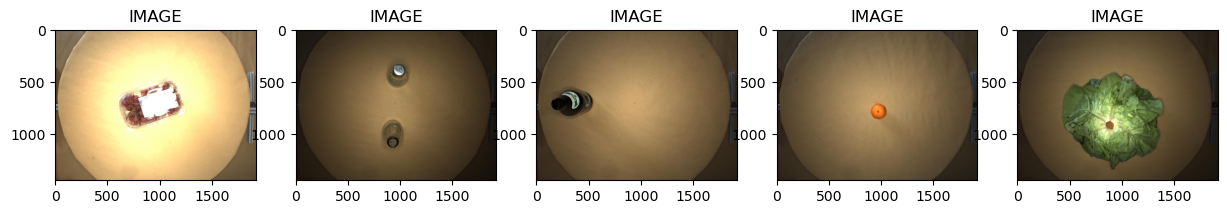

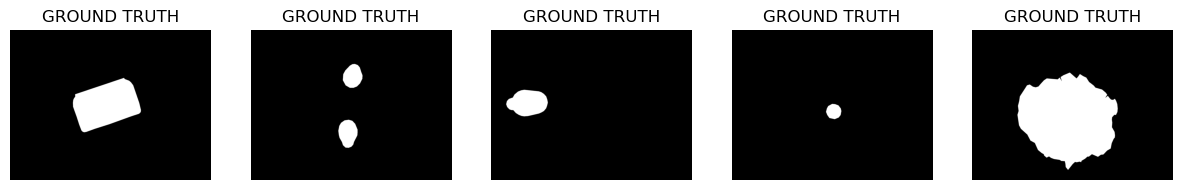

In [69]:
generate_sample_images(sample)
generate_sample_masks(sample)

In [72]:
sampled_df = df.sample(frac=0.001, random_state=57) 
train_df, val_df = train_test_split(sampled_df, test_size=0.2, random_state=57)
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),      # Horizontal Flip with 0.5 probability
        A.VerticalFlip(p=0.5)         # Vertical Flip with 0.5 probability
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

In [73]:
val_df

,image_path,mask
1931,d2s_images_v1/images/D2S_013011.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [122]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.image_path
        mask = sample['mask']

        # Read images and masks
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")
        if len(mask.shape) == 2:  # Add channel dimension if mask is grayscale
            mask = np.expand_dims(mask, axis=2)

        # Transpose image dimensions in pytorch format
        # (H,W,C) -> (C,H,W)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        # Normalize the images and masks
        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask) / 255.0

        return image, mask
    
    def __getitem2__(self, idx):
        sample = self.df.iloc[idx]
        image_path = sample.image_path
        mask = sample.mask  # Adjust based on your format

        # Load and process the image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load and process the mask
        mask = np.array(mask)
        masks = (mask > 0).astype(np.uint8)  # Convert to binary

        # Define bounding boxes for Mask R-CNN
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # Skip background

        boxes = []
        for obj_id in obj_ids:
            pos = np.where(mask == obj_id)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # Convert to tensors
        image = torch.tensor(image).permute(2, 0, 1).float() / 255.0
        masks = torch.tensor(masks, dtype=torch.uint8)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # Assuming single class

        target = {"boxes": boxes, "labels": labels, "masks": masks}
        return image, target


In [75]:
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 3
Size of Validset : 1


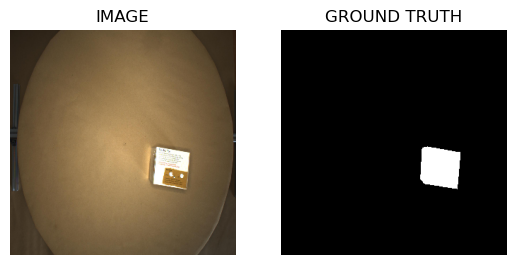

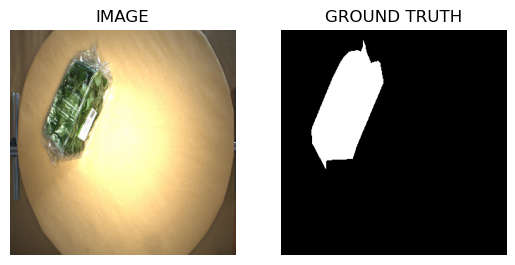

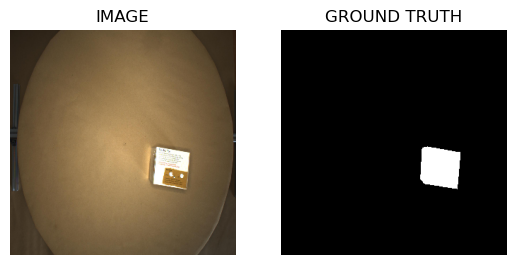

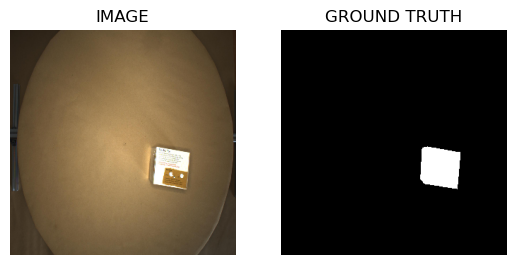

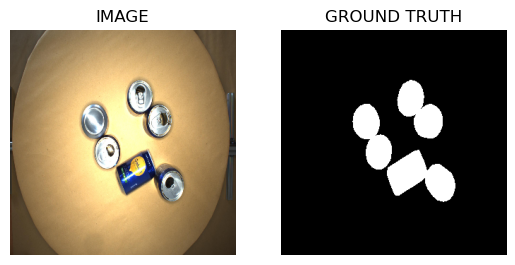

In [76]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title("IMAGE");

    plt.subplot(1,2,2)
    plt.imshow(mask.squeeze().numpy(), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH");
    plt.show()
for i in np.random.randint(0, len(train_data), 5):
    processed_image(i)

In [77]:
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")
for image, mask in trainloader:
    print(f"Size of one batch of images: {image.shape}")
    print(f"Size of one batch of masks: {mask.shape}")
    break

Total number of batches in Train Loader: 1
Total number of batches in Val Loader: 1
Size of one batch of images: torch.Size([3, 3, 320, 320])
Size of one batch of masks: torch.Size([3, 1, 320, 320])


In [78]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.model = smp.UnetPlusPlus(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None)

    def forward(self, images, masks=None):
        logits = self.model(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits


In [79]:
model = SegmentationModel()
model.to(DEVICE);

In [80]:
def train_model(data_loader, model, optimizer):
    total_loss = 0.0
    model.train()

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [81]:
def eval_model(data_loader, model):
    total_loss = 0.0
    model.eval()

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

        return total_loss / len(data_loader)

In [82]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [83]:
# Training and evaluation loop
best_val_loss = 1e9

for i in range(EPOCHS):
    train_loss = train_model(trainloader, model, optimizer)
    val_loss = eval_model(valloader, model)

    if val_loss < best_val_loss:
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pt')
        print("MODEL SAVED")

        best_val_loss = val_loss

    print(f"\033[1m\033[92m Epoch {i+1} Train Loss {train_loss} Val Loss {val_loss}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.41it/s]


MODEL SAVED
 Epoch 1 Train Loss 1.7146978378295898 Val Loss 1.5789190530776978


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


 Epoch 2 Train Loss 1.713240146636963 Val Loss 1.6588108539581299


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.28it/s]


 Epoch 3 Train Loss 1.7120354175567627 Val Loss 1.7015388011932373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


 Epoch 4 Train Loss 1.711490273475647 Val Loss 1.7227039337158203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


 Epoch 5 Train Loss 1.7095742225646973 Val Loss 1.7333803176879883


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]


 Epoch 6 Train Loss 1.7089293003082275 Val Loss 1.739574670791626


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


 Epoch 7 Train Loss 1.7076644897460938 Val Loss 1.7473102807998657


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


 Epoch 8 Train Loss 1.7066621780395508 Val Loss 1.751521348953247


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.35it/s]


 Epoch 9 Train Loss 1.7054072618484497 Val Loss 1.7531003952026367


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.14it/s]


 Epoch 10 Train Loss 1.7045536041259766 Val Loss 1.750455617904663


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


 Epoch 11 Train Loss 1.7027666568756104 Val Loss 1.7431046962738037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


 Epoch 12 Train Loss 1.7016632556915283 Val Loss 1.734149694442749


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75it/s]


 Epoch 13 Train Loss 1.7005236148834229 Val Loss 1.7264404296875


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


 Epoch 14 Train Loss 1.7002670764923096 Val Loss 1.7197928428649902


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]


 Epoch 15 Train Loss 1.6983137130737305 Val Loss 1.713710069656372


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.81it/s]


 Epoch 16 Train Loss 1.6969964504241943 Val Loss 1.7091078758239746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


 Epoch 17 Train Loss 1.6971057653427124 Val Loss 1.705519676208496


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.55it/s]


 Epoch 18 Train Loss 1.6947824954986572 Val Loss 1.7027084827423096


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.44it/s]


 Epoch 19 Train Loss 1.6952686309814453 Val Loss 1.7006516456604004


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.40it/s]


 Epoch 20 Train Loss 1.6931840181350708 Val Loss 1.699533224105835


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


 Epoch 21 Train Loss 1.6931054592132568 Val Loss 1.6990995407104492


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.43it/s]


 Epoch 22 Train Loss 1.691237449645996 Val Loss 1.699488639831543


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


 Epoch 23 Train Loss 1.691440463066101 Val Loss 1.6993803977966309


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.64it/s]


 Epoch 24 Train Loss 1.689208745956421 Val Loss 1.6989351511001587


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


 Epoch 25 Train Loss 1.6883726119995117 Val Loss 1.6989490985870361


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


 Epoch 26 Train Loss 1.6879481077194214 Val Loss 1.6989470720291138


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.97it/s]


 Epoch 27 Train Loss 1.687026023864746 Val Loss 1.6974364519119263


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


 Epoch 28 Train Loss 1.6850254535675049 Val Loss 1.6964154243469238


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.82it/s]


 Epoch 29 Train Loss 1.6842482089996338 Val Loss 1.6951627731323242


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.64it/s]


 Epoch 30 Train Loss 1.6829171180725098 Val Loss 1.694431185722351


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.85it/s]


 Epoch 31 Train Loss 1.6831649541854858 Val Loss 1.693190097808838


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.01it/s]


 Epoch 32 Train Loss 1.6813334226608276 Val Loss 1.6914453506469727


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


 Epoch 33 Train Loss 1.681060791015625 Val Loss 1.6905708312988281


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


 Epoch 34 Train Loss 1.6801960468292236 Val Loss 1.6890593767166138


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.00it/s]


 Epoch 35 Train Loss 1.678525447845459 Val Loss 1.6875941753387451


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


 Epoch 36 Train Loss 1.678337574005127 Val Loss 1.6857988834381104


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.47it/s]


 Epoch 37 Train Loss 1.6766905784606934 Val Loss 1.6840083599090576


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


 Epoch 38 Train Loss 1.6759295463562012 Val Loss 1.6823947429656982


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


 Epoch 39 Train Loss 1.6750515699386597 Val Loss 1.6805474758148193


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


 Epoch 40 Train Loss 1.6746039390563965 Val Loss 1.678711175918579


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.70it/s]


 Epoch 41 Train Loss 1.6737393140792847 Val Loss 1.676518440246582


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.95it/s]


 Epoch 42 Train Loss 1.6728628873825073 Val Loss 1.6747853755950928


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


 Epoch 43 Train Loss 1.6705982685089111 Val Loss 1.6725436449050903


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


 Epoch 44 Train Loss 1.6701183319091797 Val Loss 1.6703667640686035


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


 Epoch 45 Train Loss 1.667333722114563 Val Loss 1.6685206890106201


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.57it/s]


 Epoch 46 Train Loss 1.6684328317642212 Val Loss 1.666562557220459


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.82it/s]


 Epoch 47 Train Loss 1.6675794124603271 Val Loss 1.664795160293579


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


 Epoch 48 Train Loss 1.6665239334106445 Val Loss 1.6627933979034424


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.69it/s]


 Epoch 49 Train Loss 1.6654260158538818 Val Loss 1.6609177589416504


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


 Epoch 50 Train Loss 1.665473461151123 Val Loss 1.658670425415039


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


 Epoch 51 Train Loss 1.664750576019287 Val Loss 1.6565278768539429


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


 Epoch 52 Train Loss 1.6632335186004639 Val Loss 1.6535325050354004


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


 Epoch 53 Train Loss 1.6623293161392212 Val Loss 1.6516833305358887


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.52it/s]


 Epoch 54 Train Loss 1.661036729812622 Val Loss 1.6500167846679688


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


 Epoch 55 Train Loss 1.6606780290603638 Val Loss 1.64650297164917


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.40it/s]


 Epoch 56 Train Loss 1.6582355499267578 Val Loss 1.6447076797485352


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


 Epoch 57 Train Loss 1.658891201019287 Val Loss 1.6427792310714722


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


 Epoch 58 Train Loss 1.6583988666534424 Val Loss 1.6407654285430908


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.16it/s]


 Epoch 59 Train Loss 1.6571745872497559 Val Loss 1.639100432395935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.36it/s]


 Epoch 60 Train Loss 1.657362699508667 Val Loss 1.6374679803848267


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


 Epoch 61 Train Loss 1.6559760570526123 Val Loss 1.635678768157959


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]


 Epoch 62 Train Loss 1.654679536819458 Val Loss 1.6322896480560303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


 Epoch 63 Train Loss 1.6548160314559937 Val Loss 1.6306332349777222


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


 Epoch 64 Train Loss 1.6529417037963867 Val Loss 1.6288175582885742


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.08it/s]


 Epoch 65 Train Loss 1.6518018245697021 Val Loss 1.627371072769165


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


 Epoch 66 Train Loss 1.6508259773254395 Val Loss 1.625529408454895


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.40it/s]


 Epoch 67 Train Loss 1.6506057977676392 Val Loss 1.6235684156417847


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.32it/s]


 Epoch 68 Train Loss 1.6493782997131348 Val Loss 1.621896743774414


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


 Epoch 69 Train Loss 1.647867202758789 Val Loss 1.6197640895843506


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.25it/s]


 Epoch 70 Train Loss 1.647596836090088 Val Loss 1.617321491241455


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.72it/s]


 Epoch 71 Train Loss 1.647578477859497 Val Loss 1.6157095432281494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


 Epoch 72 Train Loss 1.6456644535064697 Val Loss 1.6126246452331543


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.90it/s]


 Epoch 73 Train Loss 1.6451088190078735 Val Loss 1.6112580299377441


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


 Epoch 74 Train Loss 1.6449594497680664 Val Loss 1.6098732948303223


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


 Epoch 75 Train Loss 1.644000768661499 Val Loss 1.607730507850647


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.45it/s]


 Epoch 76 Train Loss 1.6425647735595703 Val Loss 1.60634183883667


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71it/s]


 Epoch 77 Train Loss 1.641829252243042 Val Loss 1.6029703617095947


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


 Epoch 78 Train Loss 1.6415820121765137 Val Loss 1.6010148525238037


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.15it/s]


 Epoch 79 Train Loss 1.6412125825881958 Val Loss 1.5993552207946777


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


 Epoch 80 Train Loss 1.6392197608947754 Val Loss 1.5977652072906494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.63it/s]


 Epoch 81 Train Loss 1.6391253471374512 Val Loss 1.596023440361023


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.04it/s]


 Epoch 82 Train Loss 1.6392176151275635 Val Loss 1.594464898109436


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.36it/s]


 Epoch 83 Train Loss 1.6375906467437744 Val Loss 1.5928990840911865


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


 Epoch 84 Train Loss 1.6359639167785645 Val Loss 1.590815544128418


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.59it/s]


 Epoch 85 Train Loss 1.6357617378234863 Val Loss 1.5891156196594238


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.41it/s]


 Epoch 86 Train Loss 1.6353063583374023 Val Loss 1.5874478816986084


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.92it/s]


 Epoch 87 Train Loss 1.6343234777450562 Val Loss 1.5855495929718018


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.38it/s]


 Epoch 88 Train Loss 1.6322956085205078 Val Loss 1.5827142000198364


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


 Epoch 89 Train Loss 1.6320711374282837 Val Loss 1.581524133682251


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


MODEL SAVED
 Epoch 90 Train Loss 1.6311900615692139 Val Loss 1.5781512260437012


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.75it/s]


MODEL SAVED
 Epoch 91 Train Loss 1.6309373378753662 Val Loss 1.5765156745910645


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


MODEL SAVED
 Epoch 92 Train Loss 1.6297330856323242 Val Loss 1.575024962425232


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


MODEL SAVED
 Epoch 93 Train Loss 1.628725290298462 Val Loss 1.5736591815948486


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


MODEL SAVED
 Epoch 94 Train Loss 1.6268259286880493 Val Loss 1.5717273950576782


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.34it/s]


MODEL SAVED
 Epoch 95 Train Loss 1.6284136772155762 Val Loss 1.570312738418579


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.10it/s]


MODEL SAVED
 Epoch 96 Train Loss 1.626253604888916 Val Loss 1.5697436332702637


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.59it/s]


MODEL SAVED
 Epoch 97 Train Loss 1.625342607498169 Val Loss 1.5682026147842407


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.65it/s]


MODEL SAVED
 Epoch 98 Train Loss 1.6241786479949951 Val Loss 1.5672720670700073


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.19it/s]


MODEL SAVED
 Epoch 99 Train Loss 1.6240513324737549 Val Loss 1.5664880275726318


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.30it/s]


MODEL SAVED
 Epoch 100 Train Loss 1.6239495277404785 Val Loss 1.565448522567749


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.85it/s]


MODEL SAVED
 Epoch 101 Train Loss 1.6239666938781738 Val Loss 1.5640223026275635


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


MODEL SAVED
 Epoch 102 Train Loss 1.622314691543579 Val Loss 1.5629487037658691


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


MODEL SAVED
 Epoch 103 Train Loss 1.6216846704483032 Val Loss 1.5617904663085938


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.94it/s]


MODEL SAVED
 Epoch 104 Train Loss 1.6195659637451172 Val Loss 1.5609945058822632


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


MODEL SAVED
 Epoch 105 Train Loss 1.6192364692687988 Val Loss 1.559587001800537


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


MODEL SAVED
 Epoch 106 Train Loss 1.6185826063156128 Val Loss 1.5581319332122803


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


MODEL SAVED
 Epoch 107 Train Loss 1.6175159215927124 Val Loss 1.557241678237915


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.77it/s]


MODEL SAVED
 Epoch 108 Train Loss 1.6169966459274292 Val Loss 1.5559059381484985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.80it/s]


MODEL SAVED
 Epoch 109 Train Loss 1.6165740489959717 Val Loss 1.554565191268921


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.30it/s]


MODEL SAVED
 Epoch 110 Train Loss 1.614958643913269 Val Loss 1.5538629293441772


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.10it/s]


MODEL SAVED
 Epoch 111 Train Loss 1.6136884689331055 Val Loss 1.5525050163269043


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.44it/s]


MODEL SAVED
 Epoch 112 Train Loss 1.6137968301773071 Val Loss 1.5513944625854492


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


MODEL SAVED
 Epoch 113 Train Loss 1.6135625839233398 Val Loss 1.550107717514038


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.51it/s]


MODEL SAVED
 Epoch 114 Train Loss 1.6120610237121582 Val Loss 1.5489745140075684


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.12it/s]


MODEL SAVED
 Epoch 115 Train Loss 1.612619400024414 Val Loss 1.5481493473052979


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.88it/s]


MODEL SAVED
 Epoch 116 Train Loss 1.6104423999786377 Val Loss 1.5469977855682373


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.36it/s]


MODEL SAVED
 Epoch 117 Train Loss 1.6089327335357666 Val Loss 1.5458232164382935


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


MODEL SAVED
 Epoch 118 Train Loss 1.6096911430358887 Val Loss 1.5451809167861938


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.45it/s]


MODEL SAVED
 Epoch 119 Train Loss 1.6082425117492676 Val Loss 1.5447949171066284


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.51it/s]


MODEL SAVED
 Epoch 120 Train Loss 1.6068973541259766 Val Loss 1.5438549518585205


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.06it/s]


MODEL SAVED
 Epoch 121 Train Loss 1.6061651706695557 Val Loss 1.5430922508239746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.19it/s]


MODEL SAVED
 Epoch 122 Train Loss 1.6065971851348877 Val Loss 1.542547583580017


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.09it/s]


MODEL SAVED
 Epoch 123 Train Loss 1.6048541069030762 Val Loss 1.5418370962142944


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71it/s]


MODEL SAVED
 Epoch 124 Train Loss 1.6041215658187866 Val Loss 1.5411012172698975


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.74it/s]


MODEL SAVED
 Epoch 125 Train Loss 1.6027895212173462 Val Loss 1.5406906604766846


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.15it/s]


MODEL SAVED
 Epoch 126 Train Loss 1.6026631593704224 Val Loss 1.5393543243408203


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.96it/s]


MODEL SAVED
 Epoch 127 Train Loss 1.6013565063476562 Val Loss 1.5390069484710693


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.04it/s]


MODEL SAVED
 Epoch 128 Train Loss 1.6003086566925049 Val Loss 1.5384175777435303


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.18it/s]


MODEL SAVED
 Epoch 129 Train Loss 1.5994797945022583 Val Loss 1.5377533435821533


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


MODEL SAVED
 Epoch 130 Train Loss 1.5990629196166992 Val Loss 1.5357311964035034


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.50it/s]


MODEL SAVED
 Epoch 131 Train Loss 1.597273826599121 Val Loss 1.5351228713989258


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.35it/s]


MODEL SAVED
 Epoch 132 Train Loss 1.5963950157165527 Val Loss 1.5348182916641235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.08it/s]


MODEL SAVED
 Epoch 133 Train Loss 1.5958383083343506 Val Loss 1.5346430540084839


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


MODEL SAVED
 Epoch 134 Train Loss 1.5952527523040771 Val Loss 1.5340834856033325


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.28it/s]


MODEL SAVED
 Epoch 135 Train Loss 1.5946900844573975 Val Loss 1.5334053039550781


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.31it/s]


MODEL SAVED
 Epoch 136 Train Loss 1.5949711799621582 Val Loss 1.5328967571258545


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.60it/s]


MODEL SAVED
 Epoch 137 Train Loss 1.592624306678772 Val Loss 1.5321576595306396


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


MODEL SAVED
 Epoch 138 Train Loss 1.5925121307373047 Val Loss 1.531731128692627


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.15it/s]


MODEL SAVED
 Epoch 139 Train Loss 1.5920531749725342 Val Loss 1.5310171842575073


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.94it/s]


MODEL SAVED
 Epoch 140 Train Loss 1.590566873550415 Val Loss 1.5305402278900146


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


MODEL SAVED
 Epoch 141 Train Loss 1.590211272239685 Val Loss 1.5299034118652344


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


MODEL SAVED
 Epoch 142 Train Loss 1.5885183811187744 Val Loss 1.5293594598770142


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.84it/s]


MODEL SAVED
 Epoch 143 Train Loss 1.588128924369812 Val Loss 1.5270578861236572


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.87it/s]


MODEL SAVED
 Epoch 144 Train Loss 1.5872316360473633 Val Loss 1.5262385606765747


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


MODEL SAVED
 Epoch 145 Train Loss 1.5861928462982178 Val Loss 1.5258010625839233


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]


MODEL SAVED
 Epoch 146 Train Loss 1.5862277746200562 Val Loss 1.5253955125808716


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.13it/s]


MODEL SAVED
 Epoch 147 Train Loss 1.5849570035934448 Val Loss 1.5248661041259766


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


MODEL SAVED
 Epoch 148 Train Loss 1.5837188959121704 Val Loss 1.52420973777771


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.16it/s]


MODEL SAVED
 Epoch 149 Train Loss 1.5842845439910889 Val Loss 1.5240520238876343


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.28it/s]


MODEL SAVED
 Epoch 150 Train Loss 1.5826470851898193 Val Loss 1.5239043235778809


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


MODEL SAVED
 Epoch 151 Train Loss 1.581676721572876 Val Loss 1.5233198404312134


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.23it/s]


MODEL SAVED
 Epoch 152 Train Loss 1.5813815593719482 Val Loss 1.5229182243347168


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.31it/s]


MODEL SAVED
 Epoch 153 Train Loss 1.5800373554229736 Val Loss 1.5219228267669678


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.76it/s]


MODEL SAVED
 Epoch 154 Train Loss 1.5787522792816162 Val Loss 1.5211291313171387


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.93it/s]


MODEL SAVED
 Epoch 155 Train Loss 1.5783461332321167 Val Loss 1.5207083225250244


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.19it/s]


MODEL SAVED
 Epoch 156 Train Loss 1.5771580934524536 Val Loss 1.5203094482421875


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


MODEL SAVED
 Epoch 157 Train Loss 1.5767143964767456 Val Loss 1.5190520286560059


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.28it/s]


MODEL SAVED
 Epoch 158 Train Loss 1.5760457515716553 Val Loss 1.518147349357605


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


MODEL SAVED
 Epoch 159 Train Loss 1.5750327110290527 Val Loss 1.5172150135040283


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.25it/s]


MODEL SAVED
 Epoch 160 Train Loss 1.5744482278823853 Val Loss 1.5154950618743896


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.60it/s]


MODEL SAVED
 Epoch 161 Train Loss 1.573272943496704 Val Loss 1.5149545669555664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.72it/s]


MODEL SAVED
 Epoch 162 Train Loss 1.5728051662445068 Val Loss 1.5142604112625122


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


MODEL SAVED
 Epoch 163 Train Loss 1.5717792510986328 Val Loss 1.5132801532745361


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


MODEL SAVED
 Epoch 164 Train Loss 1.5709645748138428 Val Loss 1.5124330520629883


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


MODEL SAVED
 Epoch 165 Train Loss 1.5708520412445068 Val Loss 1.5107460021972656


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.58it/s]


MODEL SAVED
 Epoch 166 Train Loss 1.5704675912857056 Val Loss 1.510019063949585


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


MODEL SAVED
 Epoch 167 Train Loss 1.5681288242340088 Val Loss 1.5094056129455566


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.44it/s]


MODEL SAVED
 Epoch 168 Train Loss 1.5682048797607422 Val Loss 1.5090303421020508


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.60it/s]


MODEL SAVED
 Epoch 169 Train Loss 1.5675005912780762 Val Loss 1.508782982826233


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


MODEL SAVED
 Epoch 170 Train Loss 1.5662245750427246 Val Loss 1.5081491470336914


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


MODEL SAVED
 Epoch 171 Train Loss 1.565760612487793 Val Loss 1.5079258680343628


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]


MODEL SAVED
 Epoch 172 Train Loss 1.564784049987793 Val Loss 1.5073670148849487


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.90it/s]


MODEL SAVED
 Epoch 173 Train Loss 1.5638347864151 Val Loss 1.5069081783294678


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


MODEL SAVED
 Epoch 174 Train Loss 1.5639166831970215 Val Loss 1.506558895111084


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.52it/s]


MODEL SAVED
 Epoch 175 Train Loss 1.5627858638763428 Val Loss 1.506415843963623


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


MODEL SAVED
 Epoch 176 Train Loss 1.5616449117660522 Val Loss 1.5054988861083984


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


MODEL SAVED
 Epoch 177 Train Loss 1.561139464378357 Val Loss 1.504624605178833


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.36it/s]


MODEL SAVED
 Epoch 178 Train Loss 1.5603848695755005 Val Loss 1.5038524866104126


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


MODEL SAVED
 Epoch 179 Train Loss 1.559201717376709 Val Loss 1.503243088722229


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


MODEL SAVED
 Epoch 180 Train Loss 1.5580010414123535 Val Loss 1.5026025772094727


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.52it/s]


MODEL SAVED
 Epoch 181 Train Loss 1.558558702468872 Val Loss 1.502157211303711


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]


MODEL SAVED
 Epoch 182 Train Loss 1.5567141771316528 Val Loss 1.5013930797576904


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


MODEL SAVED
 Epoch 183 Train Loss 1.556342601776123 Val Loss 1.5007996559143066


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.63it/s]


MODEL SAVED
 Epoch 184 Train Loss 1.5549153089523315 Val Loss 1.4998811483383179


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.11it/s]


MODEL SAVED
 Epoch 185 Train Loss 1.5552465915679932 Val Loss 1.4991323947906494


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


MODEL SAVED
 Epoch 186 Train Loss 1.5539703369140625 Val Loss 1.4984549283981323


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


MODEL SAVED
 Epoch 187 Train Loss 1.5541255474090576 Val Loss 1.496840476989746


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.22it/s]


MODEL SAVED
 Epoch 188 Train Loss 1.552080512046814 Val Loss 1.495982050895691


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.76it/s]


MODEL SAVED
 Epoch 189 Train Loss 1.5510982275009155 Val Loss 1.495534062385559


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.30it/s]


MODEL SAVED
 Epoch 190 Train Loss 1.5511853694915771 Val Loss 1.4952549934387207


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.39it/s]


MODEL SAVED
 Epoch 191 Train Loss 1.5504931211471558 Val Loss 1.4949454069137573


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


MODEL SAVED
 Epoch 192 Train Loss 1.5493083000183105 Val Loss 1.494088888168335


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.80it/s]


MODEL SAVED
 Epoch 193 Train Loss 1.5490641593933105 Val Loss 1.493255853652954


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.04it/s]


MODEL SAVED
 Epoch 194 Train Loss 1.5479321479797363 Val Loss 1.4924263954162598


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.31it/s]


MODEL SAVED
 Epoch 195 Train Loss 1.546775460243225 Val Loss 1.4916969537734985


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


MODEL SAVED
 Epoch 196 Train Loss 1.54720139503479 Val Loss 1.4904168844223022


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


MODEL SAVED
 Epoch 197 Train Loss 1.5461931228637695 Val Loss 1.4896900653839111


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


MODEL SAVED
 Epoch 198 Train Loss 1.5446863174438477 Val Loss 1.4893604516983032


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.19it/s]


MODEL SAVED
 Epoch 199 Train Loss 1.544309139251709 Val Loss 1.4887419939041138


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


MODEL SAVED
 Epoch 200 Train Loss 1.543682336807251 Val Loss 1.4881442785263062


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.41it/s]


MODEL SAVED
 Epoch 201 Train Loss 1.542698621749878 Val Loss 1.4876785278320312


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.93it/s]


MODEL SAVED
 Epoch 202 Train Loss 1.5431573390960693 Val Loss 1.4874483346939087


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.59it/s]


MODEL SAVED
 Epoch 203 Train Loss 1.5419816970825195 Val Loss 1.4866139888763428


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


MODEL SAVED
 Epoch 204 Train Loss 1.5410619974136353 Val Loss 1.4862195253372192


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.12it/s]


MODEL SAVED
 Epoch 205 Train Loss 1.5405868291854858 Val Loss 1.4855575561523438


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.51it/s]


MODEL SAVED
 Epoch 206 Train Loss 1.539311408996582 Val Loss 1.48499596118927


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


MODEL SAVED
 Epoch 207 Train Loss 1.5393486022949219 Val Loss 1.4845508337020874


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]


MODEL SAVED
 Epoch 208 Train Loss 1.5376999378204346 Val Loss 1.4836599826812744


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.81it/s]


MODEL SAVED
 Epoch 209 Train Loss 1.5366146564483643 Val Loss 1.482548475265503


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.83it/s]


MODEL SAVED
 Epoch 210 Train Loss 1.5365839004516602 Val Loss 1.4816875457763672


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


MODEL SAVED
 Epoch 211 Train Loss 1.5361416339874268 Val Loss 1.4809421300888062


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.34it/s]


MODEL SAVED
 Epoch 212 Train Loss 1.5355966091156006 Val Loss 1.4807217121124268


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.45it/s]


MODEL SAVED
 Epoch 213 Train Loss 1.5348193645477295 Val Loss 1.4803454875946045


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.21it/s]


MODEL SAVED
 Epoch 214 Train Loss 1.5342766046524048 Val Loss 1.4798521995544434


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.68it/s]


MODEL SAVED
 Epoch 215 Train Loss 1.5332919359207153 Val Loss 1.4790756702423096


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


MODEL SAVED
 Epoch 216 Train Loss 1.533294916152954 Val Loss 1.4786659479141235


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.20it/s]


MODEL SAVED
 Epoch 217 Train Loss 1.5322082042694092 Val Loss 1.4781608581542969


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.06it/s]


MODEL SAVED
 Epoch 218 Train Loss 1.5317083597183228 Val Loss 1.4776445627212524


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.92it/s]


MODEL SAVED
 Epoch 219 Train Loss 1.5310895442962646 Val Loss 1.4770987033843994


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.50it/s]


MODEL SAVED
 Epoch 220 Train Loss 1.530798077583313 Val Loss 1.476651668548584


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.39it/s]


MODEL SAVED
 Epoch 221 Train Loss 1.5298713445663452 Val Loss 1.4759547710418701


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.67it/s]


MODEL SAVED
 Epoch 222 Train Loss 1.529137372970581 Val Loss 1.4755074977874756


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.00it/s]


MODEL SAVED
 Epoch 223 Train Loss 1.528496503829956 Val Loss 1.4751993417739868


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


MODEL SAVED
 Epoch 224 Train Loss 1.5279343128204346 Val Loss 1.474839210510254


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.01it/s]


MODEL SAVED
 Epoch 225 Train Loss 1.5275909900665283 Val Loss 1.4739561080932617


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


MODEL SAVED
 Epoch 226 Train Loss 1.5267274379730225 Val Loss 1.4732266664505005


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.12it/s]


MODEL SAVED
 Epoch 227 Train Loss 1.5261125564575195 Val Loss 1.4727751016616821


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


MODEL SAVED
 Epoch 228 Train Loss 1.5251708030700684 Val Loss 1.472447395324707


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.24it/s]


MODEL SAVED
 Epoch 229 Train Loss 1.5247828960418701 Val Loss 1.4717953205108643


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.89it/s]


MODEL SAVED
 Epoch 230 Train Loss 1.524726152420044 Val Loss 1.4706703424453735


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.93it/s]


MODEL SAVED
 Epoch 231 Train Loss 1.5239053964614868 Val Loss 1.4704768657684326


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.73it/s]


MODEL SAVED
 Epoch 232 Train Loss 1.5230318307876587 Val Loss 1.4704711437225342


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


MODEL SAVED
 Epoch 233 Train Loss 1.52277672290802 Val Loss 1.4699079990386963


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


MODEL SAVED
 Epoch 234 Train Loss 1.5221847295761108 Val Loss 1.4697685241699219


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.98it/s]


MODEL SAVED
 Epoch 235 Train Loss 1.5212445259094238 Val Loss 1.4692541360855103


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


MODEL SAVED
 Epoch 236 Train Loss 1.520681381225586 Val Loss 1.4688619375228882


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.54it/s]


MODEL SAVED
 Epoch 237 Train Loss 1.5201833248138428 Val Loss 1.4682495594024658


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]


MODEL SAVED
 Epoch 238 Train Loss 1.5198912620544434 Val Loss 1.4680511951446533


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.74it/s]


MODEL SAVED
 Epoch 239 Train Loss 1.5190048217773438 Val Loss 1.4674842357635498


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.20it/s]


MODEL SAVED
 Epoch 240 Train Loss 1.5187667608261108 Val Loss 1.4671878814697266


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.11it/s]


MODEL SAVED
 Epoch 241 Train Loss 1.5180245637893677 Val Loss 1.4664690494537354


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


MODEL SAVED
 Epoch 242 Train Loss 1.517538070678711 Val Loss 1.4661004543304443


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71it/s]


MODEL SAVED
 Epoch 243 Train Loss 1.516593337059021 Val Loss 1.465707778930664


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.25it/s]


MODEL SAVED
 Epoch 244 Train Loss 1.5160534381866455 Val Loss 1.465423822402954


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.84it/s]


MODEL SAVED
 Epoch 245 Train Loss 1.515101432800293 Val Loss 1.4649591445922852


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


MODEL SAVED
 Epoch 246 Train Loss 1.515284776687622 Val Loss 1.4646873474121094


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.17it/s]


MODEL SAVED
 Epoch 247 Train Loss 1.5147496461868286 Val Loss 1.463411569595337


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.46it/s]


MODEL SAVED
 Epoch 248 Train Loss 1.5140987634658813 Val Loss 1.462882161140442


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.82it/s]


MODEL SAVED
 Epoch 249 Train Loss 1.5128059387207031 Val Loss 1.462486982345581


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.27it/s]


MODEL SAVED
 Epoch 250 Train Loss 1.5128233432769775 Val Loss 1.462167739868164


In [84]:
# Load best model
model.load_state_dict(torch.load("best_model.pt",weights_only=True))

# Function to output the prediction mask
def make_inference(idx):
    image, mask = val_data[idx]
    logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
    print("Raw logits mask min/max:", logits_mask.min().item(), logits_mask.max().item())

    # Predicted mask
    pred_mask = torch.sigmoid(logits_mask)
    pred_mask = (torch.sigmoid(logits_mask) > 0.5) * 1.0

    return image, mask, pred_mask

Raw logits mask min/max: -4.561071872711182 3.1506006717681885
Raw logits mask min/max: -4.561071872711182 3.1506006717681885
Raw logits mask min/max: -4.561071872711182 3.1506006717681885
Raw logits mask min/max: -4.561071872711182 3.1506006717681885
Raw logits mask min/max: -4.561071872711182 3.1506006717681885


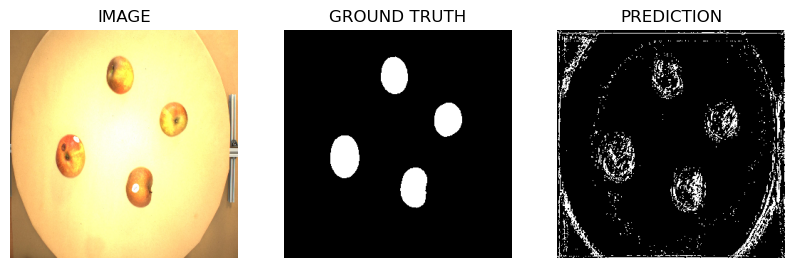

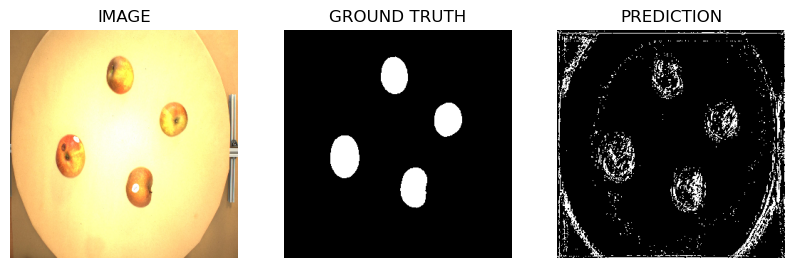

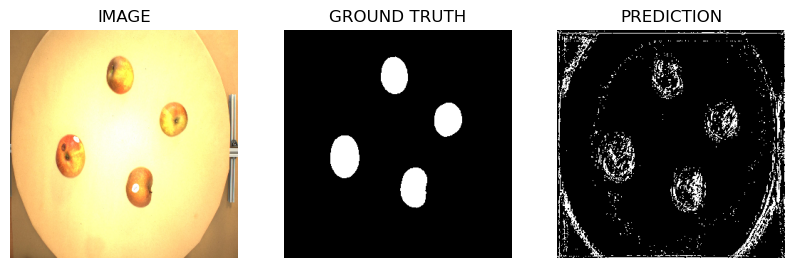

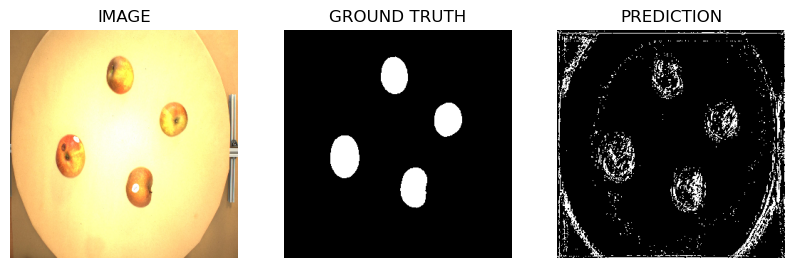

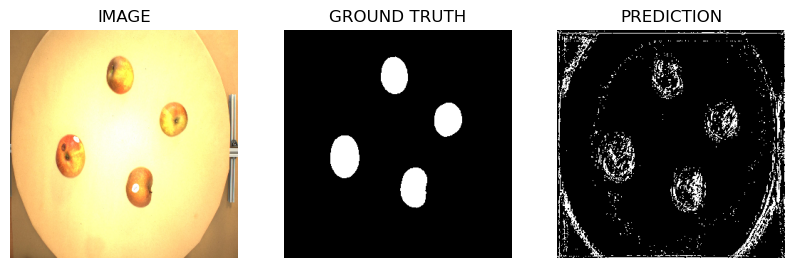

In [85]:
# Compare predictions with original
for i in np.random.randint(0, len(val_data), 5):
    image, mask, pred_mask = make_inference(i)


    # Show image
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title('IMAGE');

    # Show original mask
    plt.subplot(1,3,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('GROUND TRUTH');

    # Show predicted mask
    plt.subplot(1,3,3)
    plt.imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title('PREDICTION');

In [87]:
class UNet(nn.Module):
    
    def __init__(self, n_channels, n_classes, bilinear):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, bilinear)
        self.up2 = up(512, 128, bilinear)
        self.up3 = up(256, 64, bilinear)
        self.up4 = up(128, 64, bilinear)
        self.outc = outconv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
    

class double_conv(nn.Module):
    ''' 2 * (conv -> BN -> ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x
    

class inconv(nn.Module):
    ''' double_conv '''
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x):
        x = self.conv(x)
        return x
    

class down(nn.Module):
    ''' maxpool -> double_conv '''
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )
    
    def forward(self, x):
        x = self.mpconv(x)
        return x
    

class up(nn.Module):
    ''' upsample -> conv '''
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x1, x2):
        x1 = self.up(x1) # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2, diffY // 2, diffY - diffY//2))
        
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x
    

class outconv(nn.Module):
    ''' conv '''
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [88]:
# Example parameters, adjust `n_channels` and `n_classes` as needed
n_channels = 3  # Assuming RGB images
n_classes = 1   # Assuming binary segmentation
bilinear = True

model = UNet(n_channels, n_classes, bilinear)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [89]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [90]:
batch_size = 16  # Adjust based on your hardware
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [91]:
num_epochs = 100  

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {train_loss / len(train_loader)}")
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}")


Epoch 1/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


Epoch 1, Training Loss: 0.5229492783546448


Epoch 1/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.79it/s]


Epoch 1, Validation Loss: 0.6294252276420593


Epoch 2/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 2, Training Loss: 0.4789941608905792


Epoch 2/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.17it/s]


Epoch 2, Validation Loss: 0.6236340999603271


Epoch 3/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch 3, Training Loss: 0.4545494318008423


Epoch 3/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


Epoch 3, Validation Loss: 0.6172311902046204


Epoch 4/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch 4, Training Loss: 0.4374753534793854


Epoch 4/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.48it/s]


Epoch 4, Validation Loss: 0.6110550165176392


Epoch 5/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Epoch 5, Training Loss: 0.42212969064712524


Epoch 5/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


Epoch 5, Validation Loss: 0.6048751473426819


Epoch 6/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 6, Training Loss: 0.4096640646457672


Epoch 6/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


Epoch 6, Validation Loss: 0.5986279845237732


Epoch 7/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Epoch 7, Training Loss: 0.39921966195106506


Epoch 7/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.83it/s]


Epoch 7, Validation Loss: 0.5924076437950134


Epoch 8/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.77it/s]


Epoch 8, Training Loss: 0.39189454913139343


Epoch 8/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.76it/s]


Epoch 8, Validation Loss: 0.5864749550819397


Epoch 9/100 - Training: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 9, Training Loss: 0.384287029504776


Epoch 9/100 - Validation: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Epoch 9, Validation Loss: 0.5807492733001709


Epoch 10/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch 10, Training Loss: 0.37778398394584656


Epoch 10/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.43it/s]


Epoch 10, Validation Loss: 0.5751023292541504


Epoch 11/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 11, Training Loss: 0.3706852197647095


Epoch 11/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.11it/s]


Epoch 11, Validation Loss: 0.5696801543235779


Epoch 12/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch 12, Training Loss: 0.3656681776046753


Epoch 12/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.05it/s]


Epoch 12, Validation Loss: 0.564617931842804


Epoch 13/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 13, Training Loss: 0.35969650745391846


Epoch 13/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.04it/s]


Epoch 13, Validation Loss: 0.5600008964538574


Epoch 14/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch 14, Training Loss: 0.35463041067123413


Epoch 14/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.26it/s]


Epoch 14, Validation Loss: 0.5558544993400574


Epoch 15/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Epoch 15, Training Loss: 0.35036805272102356


Epoch 15/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.54it/s]


Epoch 15, Validation Loss: 0.5519084334373474


Epoch 16/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Epoch 16, Training Loss: 0.34470897912979126


Epoch 16/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.14it/s]


Epoch 16, Validation Loss: 0.5479676723480225


Epoch 17/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Epoch 17, Training Loss: 0.34048300981521606


Epoch 17/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.93it/s]


Epoch 17, Validation Loss: 0.5437177419662476


Epoch 18/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Epoch 18, Training Loss: 0.33588695526123047


Epoch 18/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.42it/s]


Epoch 18, Validation Loss: 0.5386182069778442


Epoch 19/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Epoch 19, Training Loss: 0.33187034726142883


Epoch 19/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.40it/s]


Epoch 19, Validation Loss: 0.5330870151519775


Epoch 20/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch 20, Training Loss: 0.32803481817245483


Epoch 20/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Epoch 20, Validation Loss: 0.52613365650177


Epoch 21/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch 21, Training Loss: 0.3231333792209625


Epoch 21/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.83it/s]


Epoch 21, Validation Loss: 0.517638087272644


Epoch 22/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch 22, Training Loss: 0.3188195824623108


Epoch 22/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.91it/s]


Epoch 22, Validation Loss: 0.5065557956695557


Epoch 23/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 23, Training Loss: 0.3144998848438263


Epoch 23/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


Epoch 23, Validation Loss: 0.4928991496562958


Epoch 24/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Epoch 24, Training Loss: 0.31135666370391846


Epoch 24/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Epoch 24, Validation Loss: 0.47897061705589294


Epoch 25/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 25, Training Loss: 0.30650725960731506


Epoch 25/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Epoch 25, Validation Loss: 0.4650033414363861


Epoch 26/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 26, Training Loss: 0.30340754985809326


Epoch 26/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.12it/s]


Epoch 26, Validation Loss: 0.4519580602645874


Epoch 27/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 27, Training Loss: 0.29909196496009827


Epoch 27/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


Epoch 27, Validation Loss: 0.43904373049736023


Epoch 28/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 28, Training Loss: 0.29704636335372925


Epoch 28/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


Epoch 28, Validation Loss: 0.42723989486694336


Epoch 29/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch 29, Training Loss: 0.2932329475879669


Epoch 29/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


Epoch 29, Validation Loss: 0.41488364338874817


Epoch 30/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch 30, Training Loss: 0.2904534637928009


Epoch 30/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.68it/s]


Epoch 30, Validation Loss: 0.4024319350719452


Epoch 31/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch 31, Training Loss: 0.28676584362983704


Epoch 31/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.15it/s]


Epoch 31, Validation Loss: 0.39014148712158203


Epoch 32/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch 32, Training Loss: 0.2847577929496765


Epoch 32/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.49it/s]


Epoch 32, Validation Loss: 0.37910550832748413


Epoch 33/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 33, Training Loss: 0.28243425488471985


Epoch 33/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]


Epoch 33, Validation Loss: 0.3709026277065277


Epoch 34/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 34, Training Loss: 0.2800823748111725


Epoch 34/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.71it/s]


Epoch 34, Validation Loss: 0.3646586835384369


Epoch 35/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 35, Training Loss: 0.27851852774620056


Epoch 35/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


Epoch 35, Validation Loss: 0.3593066334724426


Epoch 36/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch 36, Training Loss: 0.2771257162094116


Epoch 36/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.80it/s]


Epoch 36, Validation Loss: 0.353036493062973


Epoch 37/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 37, Training Loss: 0.2757701575756073


Epoch 37/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.07it/s]


Epoch 37, Validation Loss: 0.34657058119773865


Epoch 38/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch 38, Training Loss: 0.27306681871414185


Epoch 38/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.16it/s]


Epoch 38, Validation Loss: 0.3408837914466858


Epoch 39/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 39, Training Loss: 0.2711205780506134


Epoch 39/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.25it/s]


Epoch 39, Validation Loss: 0.3351306915283203


Epoch 40/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Epoch 40, Training Loss: 0.2696276009082794


Epoch 40/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.32it/s]


Epoch 40, Validation Loss: 0.33044272661209106


Epoch 41/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch 41, Training Loss: 0.2682918310165405


Epoch 41/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Epoch 41, Validation Loss: 0.3245425820350647


Epoch 42/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Epoch 42, Training Loss: 0.267155259847641


Epoch 42/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.09it/s]


Epoch 42, Validation Loss: 0.31826919317245483


Epoch 43/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 43, Training Loss: 0.26569825410842896


Epoch 43/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


Epoch 43, Validation Loss: 0.31235018372535706


Epoch 44/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Epoch 44, Training Loss: 0.26530107855796814


Epoch 44/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.78it/s]


Epoch 44, Validation Loss: 0.3073681890964508


Epoch 45/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch 45, Training Loss: 0.2646477520465851


Epoch 45/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.05it/s]


Epoch 45, Validation Loss: 0.30337604880332947


Epoch 46/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch 46, Training Loss: 0.2617647349834442


Epoch 46/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.94it/s]


Epoch 46, Validation Loss: 0.29969438910484314


Epoch 47/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 47, Training Loss: 0.26334449648857117


Epoch 47/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.16it/s]


Epoch 47, Validation Loss: 0.296440988779068


Epoch 48/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch 48, Training Loss: 0.259883850812912


Epoch 48/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.86it/s]


Epoch 48, Validation Loss: 0.2944936752319336


Epoch 49/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Epoch 49, Training Loss: 0.2598484754562378


Epoch 49/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.83it/s]


Epoch 49, Validation Loss: 0.29545605182647705


Epoch 50/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 50, Training Loss: 0.258910596370697


Epoch 50/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.23it/s]


Epoch 50, Validation Loss: 0.29718053340911865


Epoch 51/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch 51, Training Loss: 0.2574598789215088


Epoch 51/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.02it/s]


Epoch 51, Validation Loss: 0.29910945892333984


Epoch 52/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch 52, Training Loss: 0.2565666139125824


Epoch 52/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.52it/s]


Epoch 52, Validation Loss: 0.2918190062046051


Epoch 53/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch 53, Training Loss: 0.25518760085105896


Epoch 53/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.65it/s]


Epoch 53, Validation Loss: 0.2790844738483429


Epoch 54/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Epoch 54, Training Loss: 0.2542498707771301


Epoch 54/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.51it/s]


Epoch 54, Validation Loss: 0.2718369662761688


Epoch 55/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Epoch 55, Training Loss: 0.2532714307308197


Epoch 55/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.50it/s]


Epoch 55, Validation Loss: 0.2660174071788788


Epoch 56/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Epoch 56, Training Loss: 0.2519669532775879


Epoch 56/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.00it/s]


Epoch 56, Validation Loss: 0.26384586095809937


Epoch 57/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch 57, Training Loss: 0.25069716572761536


Epoch 57/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.29it/s]


Epoch 57, Validation Loss: 0.2626674473285675


Epoch 58/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Epoch 58, Training Loss: 0.25002121925354004


Epoch 58/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.98it/s]


Epoch 58, Validation Loss: 0.2615617513656616


Epoch 59/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


Epoch 59, Training Loss: 0.2493007481098175


Epoch 59/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.95it/s]


Epoch 59, Validation Loss: 0.2613574266433716


Epoch 60/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.10s/it]


Epoch 60, Training Loss: 0.24859029054641724


Epoch 60/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.95it/s]


Epoch 60, Validation Loss: 0.2589419484138489


Epoch 61/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Epoch 61, Training Loss: 0.2476281225681305


Epoch 61/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


Epoch 61, Validation Loss: 0.2551558315753937


Epoch 62/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch 62, Training Loss: 0.24668709933757782


Epoch 62/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.86it/s]


Epoch 62, Validation Loss: 0.25099754333496094


Epoch 63/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Epoch 63, Training Loss: 0.24567531049251556


Epoch 63/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 63, Validation Loss: 0.24706360697746277


Epoch 64/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Epoch 64, Training Loss: 0.2452271580696106


Epoch 64/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.80it/s]


Epoch 64, Validation Loss: 0.24650157988071442


Epoch 65/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 65, Training Loss: 0.24418869614601135


Epoch 65/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.24it/s]


Epoch 65, Validation Loss: 0.24651138484477997


Epoch 66/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch 66, Training Loss: 0.2434360533952713


Epoch 66/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Epoch 66, Validation Loss: 0.24619990587234497


Epoch 67/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch 67, Training Loss: 0.24274565279483795


Epoch 67/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.22it/s]


Epoch 67, Validation Loss: 0.24573977291584015


Epoch 68/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch 68, Training Loss: 0.2418719232082367


Epoch 68/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


Epoch 68, Validation Loss: 0.2446337789297104


Epoch 69/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 69, Training Loss: 0.24129308760166168


Epoch 69/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


Epoch 69, Validation Loss: 0.24695543944835663


Epoch 70/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 70, Training Loss: 0.24071674048900604


Epoch 70/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


Epoch 70, Validation Loss: 0.24462048709392548


Epoch 71/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 71, Training Loss: 0.23992493748664856


Epoch 71/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.84it/s]


Epoch 71, Validation Loss: 0.23950456082820892


Epoch 72/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch 72, Training Loss: 0.2390928715467453


Epoch 72/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.46it/s]


Epoch 72, Validation Loss: 0.2377815693616867


Epoch 73/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch 73, Training Loss: 0.23818014562129974


Epoch 73/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.79it/s]


Epoch 73, Validation Loss: 0.23755377531051636


Epoch 74/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Epoch 74, Training Loss: 0.23735959827899933


Epoch 74/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Epoch 74, Validation Loss: 0.23757882416248322


Epoch 75/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 75, Training Loss: 0.23672962188720703


Epoch 75/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


Epoch 75, Validation Loss: 0.23515979945659637


Epoch 76/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Epoch 76, Training Loss: 0.23602549731731415


Epoch 76/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.18it/s]


Epoch 76, Validation Loss: 0.23367524147033691


Epoch 77/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch 77, Training Loss: 0.23530292510986328


Epoch 77/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.42it/s]


Epoch 77, Validation Loss: 0.234526589512825


Epoch 78/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Epoch 78, Training Loss: 0.2346428483724594


Epoch 78/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.67it/s]


Epoch 78, Validation Loss: 0.23317940533161163


Epoch 79/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch 79, Training Loss: 0.2340002804994583


Epoch 79/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.51it/s]


Epoch 79, Validation Loss: 0.23231685161590576


Epoch 80/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Epoch 80, Training Loss: 0.23337964713573456


Epoch 80/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.24it/s]


Epoch 80, Validation Loss: 0.23586881160736084


Epoch 81/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch 81, Training Loss: 0.23271574079990387


Epoch 81/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.71it/s]


Epoch 81, Validation Loss: 0.23379062116146088


Epoch 82/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch 82, Training Loss: 0.23207594454288483


Epoch 82/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.59it/s]


Epoch 82, Validation Loss: 0.23210082948207855


Epoch 83/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Epoch 83, Training Loss: 0.23138557374477386


Epoch 83/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.53it/s]


Epoch 83, Validation Loss: 0.23271363973617554


Epoch 84/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Epoch 84, Training Loss: 0.23082199692726135


Epoch 84/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


Epoch 84, Validation Loss: 0.22874556481838226


Epoch 85/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 85, Training Loss: 0.23102021217346191


Epoch 85/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.91it/s]


Epoch 85, Validation Loss: 0.3577215373516083


Epoch 86/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch 86, Training Loss: 0.23225998878479004


Epoch 86/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


Epoch 86, Validation Loss: 0.49973440170288086


Epoch 87/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 87, Training Loss: 0.2329503446817398


Epoch 87/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


Epoch 87, Validation Loss: 0.469634085893631


Epoch 88/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch 88, Training Loss: 0.23276080191135406


Epoch 88/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


Epoch 88, Validation Loss: 0.3783378601074219


Epoch 89/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch 89, Training Loss: 0.23292303085327148


Epoch 89/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.96it/s]


Epoch 89, Validation Loss: 0.32528555393218994


Epoch 90/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Epoch 90, Training Loss: 0.2310459464788437


Epoch 90/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.80it/s]


Epoch 90, Validation Loss: 0.3031841516494751


Epoch 91/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.32it/s]


Epoch 91, Training Loss: 0.2297099083662033


Epoch 91/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


Epoch 91, Validation Loss: 0.2826272249221802


Epoch 92/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch 92, Training Loss: 0.2291545420885086


Epoch 92/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.09it/s]


Epoch 92, Validation Loss: 0.25429296493530273


Epoch 93/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Epoch 93, Training Loss: 0.22825032472610474


Epoch 93/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Epoch 93, Validation Loss: 0.2347988337278366


Epoch 94/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch 94, Training Loss: 0.22730448842048645


Epoch 94/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


Epoch 94, Validation Loss: 0.22814981639385223


Epoch 95/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch 95, Training Loss: 0.2266862541437149


Epoch 95/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.78it/s]


Epoch 95, Validation Loss: 0.22894994914531708


Epoch 96/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch 96, Training Loss: 0.22595418989658356


Epoch 96/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


Epoch 96, Validation Loss: 0.23067286610603333


Epoch 97/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch 97, Training Loss: 0.2250281274318695


Epoch 97/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.60it/s]


Epoch 97, Validation Loss: 0.23134534060955048


Epoch 98/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch 98, Training Loss: 0.22461073100566864


Epoch 98/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.86it/s]


Epoch 98, Validation Loss: 0.2293967455625534


Epoch 99/100 - Training: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Epoch 99, Training Loss: 0.22389544546604156


Epoch 99/100 - Validation: 100%|█████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.16it/s]


Epoch 99, Validation Loss: 0.2249213010072708


Epoch 100/100 - Training: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch 100, Training Loss: 0.22331126034259796


Epoch 100/100 - Validation: 100%|████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]

Epoch 100, Validation Loss: 0.22016677260398865


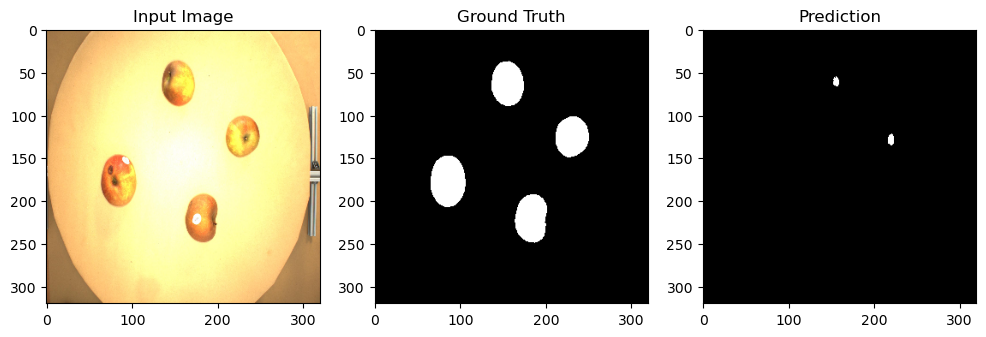

In [92]:
import matplotlib.pyplot as plt

# Example: Visualize a few predictions
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = (outputs > 0.5).float()  # Binarize output
        
        # Plot the first sample in the batch
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(images[0].cpu().permute(1, 2, 0))
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(masks[0].cpu().squeeze(), cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(outputs[0].cpu().squeeze(), cmap="gray")
        plt.show()
        break
